# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

from pyspark.sql.types import IntegerType, BooleanType, DateType
from pyspark.sql.functions import udf, concat, col, lit, avg, stddev, count, desc
from pyspark.sql.window import Window
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, GBTClassifier, MultilayerPerceptronClassifier 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
# set Seaborn style & color palette
sns.set_style("whitegrid")
sns.set_palette("hls", 2)

In [4]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
def print_shape(df):
    """
    Method imitating the pandas .shape property.
    
    Args: 
        df: pyspark.DataFrame
    
    Returns:
        None
    """
    
    print("(", df.count(), ",", len(df.columns), ")")

In [6]:
sparkify_data = "mini_sparkify_event_data.json"  # define the data file

df = spark.read.json(sparkify_data)  # read the json file
df.persist()  # persist the data in memory

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [9]:
print_shape(df)

( 286500 , 18 )


In [10]:
print("Rows: ", df.count())  # get the shape of the df
print("Cols: ", len(df.columns))

Rows:  286500
Cols:  18


In [11]:
df_clean = df.filter((df.userId != "") | (df.sessionId != ""))  # remove rows where either userId or sessionId is empty
print("Rows: ", df_clean.count())
print("Cols: ", len(df_clean.columns))

Rows:  278154
Cols:  18


In [12]:
print("Numb. unique IDs: ")
df_clean.select(F.countDistinct("userId")).show()

Numb. unique IDs: 
+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Defining Churn

In [13]:
def plot_barplot(df, x, y, hue, print_vals, plt_labels, title_list, figsize=(4,3)):
    """
    Plot an sns barplot given a set of params.
    
    Args:
        df: pd.DataFrame; in sns format!
        x: str; xcol
        y: str; ycol
        hue: str;
        print_vals: bool; check if df should be printed
        plt_labels: list(str); 
        title_list: list(str); fig title, x title, y title
        figsize: tuple(int, int)
        
    Returns:
        None
    """
    
    plt.figure(figsize=figsize)  # set the figsize
    sns.barplot(data=df, x=x, y=y, hue=hue)  # sns barplot
    
    if plt_labels:
        plt.xticks(np.arange(len(plt_labels)), plt_labels)  # set predefined xlabels
        
    plt.title(title_list[0])
    plt.xlabel(title_list[1])
    plt.ylabel(title_list[2])
    
    plt.grid(True)
    
    if print_vals:
        print(df.head())

In [14]:
df_clean.groupBy("page").count().orderBy("count", ascending=False).collect()  # get all types of events

[Row(page='NextSong', count=228108),
 Row(page='Thumbs Up', count=12551),
 Row(page='Home', count=10082),
 Row(page='Add to Playlist', count=6526),
 Row(page='Add Friend', count=4277),
 Row(page='Roll Advert', count=3933),
 Row(page='Logout', count=3226),
 Row(page='Thumbs Down', count=2546),
 Row(page='Downgrade', count=2055),
 Row(page='Settings', count=1514),
 Row(page='Help', count=1454),
 Row(page='Upgrade', count=499),
 Row(page='About', count=495),
 Row(page='Save Settings', count=310),
 Row(page='Error', count=252),
 Row(page='Submit Upgrade', count=159),
 Row(page='Submit Downgrade', count=63),
 Row(page='Cancel', count=52),
 Row(page='Cancellation Confirmation', count=52)]

In [15]:
df_clean[df_clean.page == "Error"].show(2)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method| page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|     Kael|     M|           48|   Baker|  null| paid|Kingsport-Bristol...|   GET|Error|1533102330000|      249|null|   404|1538393848000|"Mozilla/5.0 (Mac...|   131|
|  null|Logged In|   Lucero|     F|           10|    Reed|  null| free|Louisville/Jeffer...|   GET|Error|1536642109000|      139|null|   404|1538407927000|"Mozilla/5.0 (Win...|   140|
+------+---------+---------+------+-------------+--------+------+-----+---------

In [16]:
user_window = Window.partitionBy("userId")  # create windows separating each user by ID

# make a flag for "Submit Downgrade" events
downgrade_check = udf(lambda x: x == "Submit Downgrade", BooleanType())
df_clean = df_clean.withColumn("downgrade_flag", downgrade_check(df.page).cast('integer'))  # cast to int

# label users who downgraded
df_clean = df_clean.withColumn("user_downgrade", F.max("downgrade_flag").over(user_window))


# make a flag for "Cancellation Confirmation" events
cancellation_check = udf(lambda x: x == "Cancellation Confirmation", BooleanType())
df_clean = df_clean.withColumn("cancel_flag", cancellation_check(df.page).cast('integer'))  # cast to int

# label users who cancelled
df_clean = df_clean.withColumn("user_cancel", F.max("cancel_flag").over(user_window))


# # make a flag for both events
# churn_check = udf(lambda x: (x == "Submit Downgrade") | (x == "Cancellation Confirmation"), BooleanType())
# df_clean = df_clean.withColumn("churn_flag", churn_check(df.page).cast('integer'))  # cast to int

# # label users for both events 
# #df_clean = df_clean.withColumn("user_churn", F.max("churn_flag").over(user_window))
# churn_window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# df_clean = df_clean.withColumn("user_churn", F.max('churn_flag').over(churn_window))

   user_cancel  count
0            1     52
1            0    173


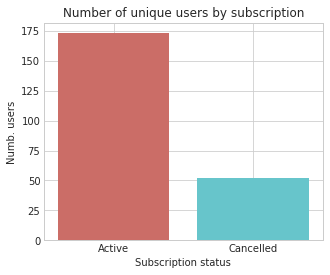

In [17]:
df_cancel_pd = df_clean.drop_duplicates(["userId"]).groupby(["user_cancel"]).count().toPandas()  # pd df for barplots

# make plot
plot_barplot(df_cancel_pd, x="user_cancel", y="count", hue=None, print_vals=True, plt_labels=["Active", "Cancelled"],
           title_list=['Number of unique users by subscription',
                      'Subscription status',
                      'Numb. users'],
            figsize=(5,4))

   user_downgrade  count
0               1     49
1               0    176


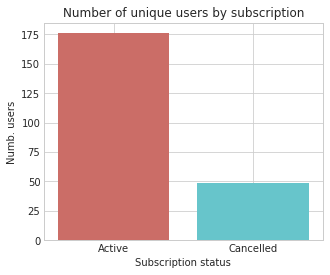

In [18]:
df_downgrade_pd = df_clean.drop_duplicates(["userId"]).groupby(["user_downgrade"]).count().toPandas()  # pd df for barplots

# make plot
plot_barplot(df_downgrade_pd, x="user_downgrade", y="count", hue=None, print_vals=True, plt_labels=["Active", "Cancelled"],
           title_list=['Number of unique users by subscription',
                      'Subscription status',
                      'Numb. users'],
            figsize=(5,4))

### Data Exploration

In [19]:
# define methods for 
song = udf(lambda x : int(x=='NextSong'), IntegerType())
home_visit = udf(lambda x : int(x=='Home'), IntegerType())

In [20]:
#distribution of users downgrades and cancellations
df_clean.select(['userId', 'user_cancel'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(user_cancel)', 'churn').describe().show()

+-------+------------------+------------------+
|summary|            userId|             churn|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|199.39555555555555|
| stddev|105396.47791907164| 546.1125022911765|
|    min|                10|                 0|
|    max|                99|              3603|
+-------+------------------+------------------+



In [21]:
time_window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# df_clean = df_clean.withColumn("cum_sum_churn", F.sum("user_cancel").over(time_window))

In [22]:
# average number of songs player for users which churned
df_clean.filter(col('user_cancel')==1).withColumn("songPlayed", song(col('page'))).agg({'songPlayed':"mean"}).show()

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8112072039942939|
+------------------+



In [23]:
# average number of songs player for users which stayed
df_clean.filter(col('user_cancel')!=1).withColumn("songPlayed", song(col('page'))).agg({'songPlayed':"mean"}).show()

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8217840456084702|
+------------------+



In [24]:
#number of songs played between home visits
cusum = df_clean.filter((df_clean.page == 'NextSong') | (df_clean.page == 'Home')) \
    .select('userID', 'page', 'ts', 'user_cancel') \
    .withColumn('homevisit', home_visit(col('page'))) \
    .withColumn('songPeriod', F.sum('homevisit').over(time_window))

cusum.filter((cusum.user_cancel == 1) & (cusum.page == 'NextSong')) \
    .groupBy('userID', 'songPeriod') \
    .agg({'songPeriod':'count'}) \
    .agg({'count(songPeriod)':'avg'}).show()

cusum.filter((cusum.user_cancel == 0) & (cusum.page == 'NextSong')) \
    .groupBy('userID', 'songPeriod') \
    .agg({'songPeriod':'count'}) \
    .agg({'count(songPeriod)':'avg'}).show()

+----------------------+
|avg(count(songPeriod))|
+----------------------+
|      22.6612702366127|
+----------------------+

+----------------------+
|avg(count(songPeriod))|
+----------------------+
|     23.79175974187143|
+----------------------+



   user_cancel gender  count
0            0      M     89
1            0      F     84
2            1      F     20
3            1      M     32


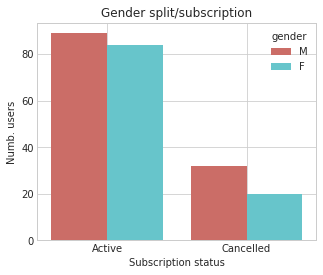

In [25]:
# Barplot for the gender distribution/subscription status
df_cancel_pd = df_clean.drop_duplicates(['userId']).groupby(['user_cancel', 'gender']).count().sort("user_cancel").toPandas()

# make plot
plot_barplot(df_cancel_pd, x="user_cancel", y="count", hue="gender", print_vals=True, plt_labels=["Active", "Cancelled"],
           title_list=["Gender split/subscription",
                      "Subscription status",
                      "Numb. users"],
            figsize=(5,4))

   user_cancel level  count
0            0  free    149
1            0  paid    129
2            1  paid     36
3            1  free     46


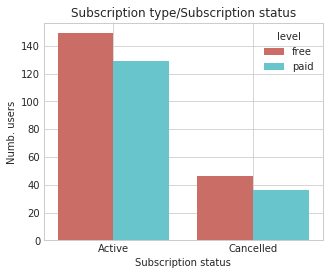

In [26]:
# Barplot for subscription type/subscription status
df_level_pd = df_clean.drop_duplicates(['userId', 'user_cancel', 'level']).groupby(['user_cancel', 'level']).count().sort("user_cancel").toPandas()

# make plot
plot_barplot(df_level_pd, x="user_cancel", y="count", hue="level", print_vals=True, plt_labels=["Active", "Cancelled"],
           title_list=["Subscription type/Subscription status",
                      "Subscription status",
                      "Numb. users"],
            figsize=(5,4))

#### Plot events/subscription type

              page user_cancel      count
0            About      Active   1.055898
1            About   Cancelled   0.661157
2       Add Friend      Active   8.757456
3       Add Friend   Cancelled   7.508855
4  Add to Playlist      Active  13.199923


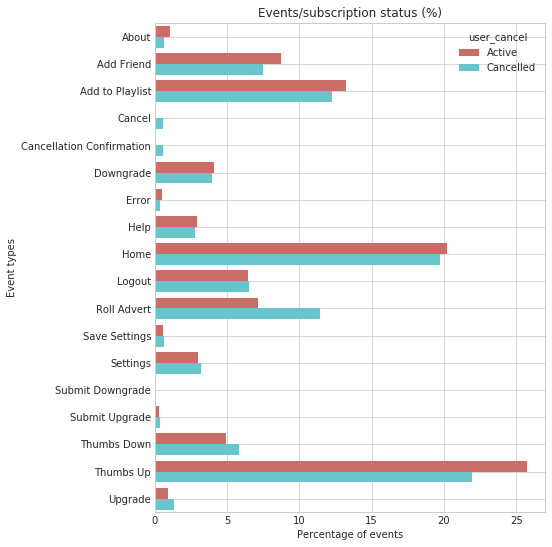

In [27]:
# Barplot for events/subscription status

# create the events df
df_events_pd = df_clean.groupby(['page','user_cancel']).count().toPandas()  # get a count of all events

df_events_pd['user_cancel'].replace({0:'Active', 1: 'Cancelled'}, inplace = True)  # replace the 0, 1 labels to text

df_events_pd = df_events_pd[df_events_pd['page'] != 'NextSong']  # remove NextSong as it dominates

df_events_pd = ((df_events_pd.groupby(['page','user_cancel']).sum() / 
                 df_events_pd.groupby(['user_cancel']).sum()) * 100).reset_index()  # get counts in percentage

# make barplot. This adds to 100% of total events that are not NextSong 
plot_barplot(df_events_pd, x="count", y="page", hue="user_cancel", print_vals=True, plt_labels=None,
           title_list=["Events/subscription status (%)",
                      "Percentage of events",
                      "Event types"],
            figsize=(7,9))

In [28]:
# add columns for day, weekday and hour based on timestamp
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).day)  # day
df_clean = df_clean.withColumn("day", get_day(df_clean.ts))

get_wkday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).weekday())  # weekday
df_clean = df_clean.withColumn("wkday", get_wkday(df_clean.ts))

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).hour)  # hour
df_clean = df_clean.withColumn("hour", get_hour(df_clean.ts))

#### Plot events/day-of-month

    day user_cancel     count
0     1      Active  3.965879
1     1   Cancelled  4.560449
23    2   Cancelled  5.596915
22    2      Active  4.000171
45    3   Cancelled  4.266227


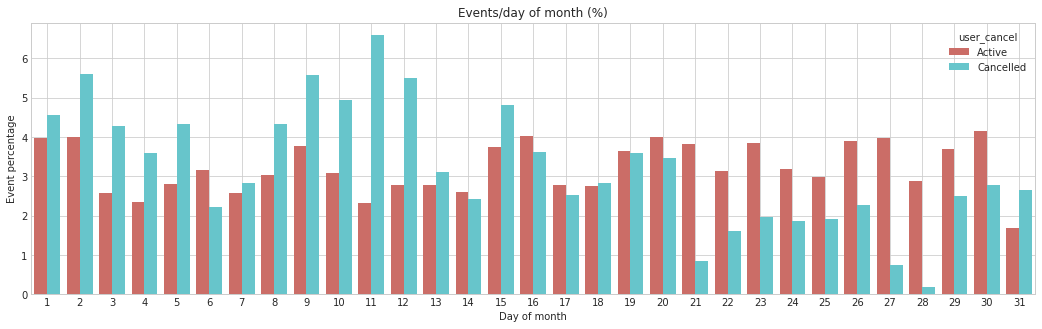

In [29]:
df_day = df_clean.groupby(["day", "user_cancel"]).count().toPandas()
df_day = ((df_day.groupby(['day', 'user_cancel']).sum() / 
           df_day.groupby(['user_cancel']).sum()) * 100).reset_index()

df_day['user_cancel'].replace({0:'Active', 1: 'Cancelled'}, inplace = True)  # replace the 0, 1 labels to text

df_day["day"] = df_day["day"].astype(int)  # convert the str day index to int

df_day.sort_values(by = ["day"], ascending=True, inplace = True)  # sort days in asceding order

# make barplot
plot_barplot(df_day, x="day", y="count", hue="user_cancel", print_vals=True, plt_labels=None,
           title_list=["Events/day of month (%)",
                      "Day of month",
                      "Event percentage"],
            figsize=(18,5))

#### Plot events/weekday

   wkday user_cancel      count
0      0      Active  15.560461
1      0   Cancelled  15.493491
2      1      Active  17.017446
3      1   Cancelled  17.082739
4      2      Active  16.578936


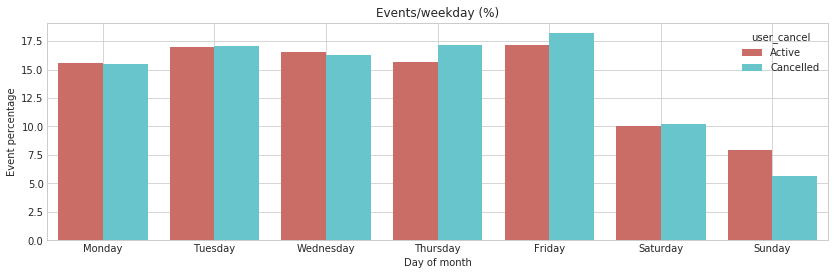

In [30]:
df_wkday = df_clean.groupby(["wkday", "user_cancel"]).count().toPandas()
df_wkday = ((df_wkday.groupby(['wkday', 'user_cancel']).sum() / 
           df_wkday.groupby(['user_cancel']).sum()) * 100).reset_index()

df_wkday['user_cancel'].replace({0:'Active', 1: 'Cancelled'}, inplace = True)  # replace the 0, 1 labels to text

df_wkday["wkday"] = df_wkday["wkday"].astype(int)  # convert the str wkday index to int

df_wkday.sort_values(by = ["wkday"], ascending=True, inplace = True)  # sort wkday in asceding order

# make barplot
plot_barplot(df_wkday, x="wkday", y="count", hue="user_cancel", print_vals=True, 
            plt_labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
            title_list=["Events/weekday (%)",
                      "Day of month",
                      "Event percentage"],
            figsize=(14,4))

#### Plot songs played/hour

    hour user_cancel     count
0      0      Active  3.926161
1      0   Cancelled  4.217728
2      1      Active  3.669529
3      1   Cancelled  3.717646
25     2   Cancelled  3.632467


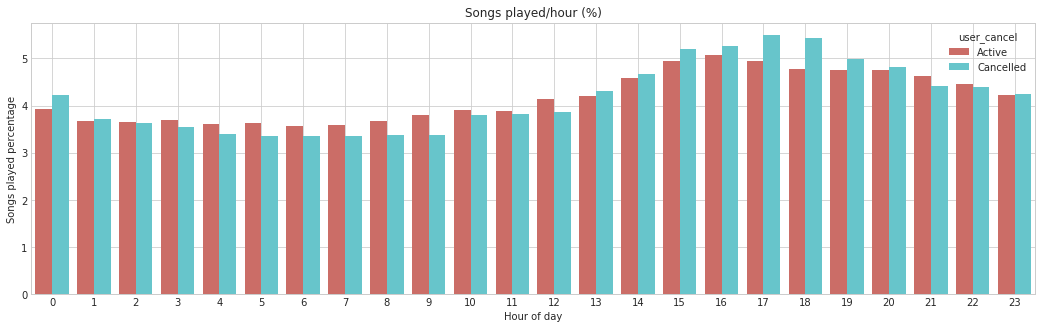

In [31]:
df_songs = df_clean.filter(df_clean["page"] == "NextSong")  # get only the NextSong events

df_songs = df_songs.groupby(["hour", "user_cancel"]).count().toPandas()
df_songs = ((df_songs.groupby(['hour', 'user_cancel']).sum() / 
           df_songs.groupby(['user_cancel']).sum()) * 100).reset_index()

df_songs['user_cancel'].replace({0:'Active', 1: 'Cancelled'}, inplace = True)  # replace the 0, 1 labels to text

df_songs["hour"] = df_songs["hour"].astype(int)  # convert the str hour to int

df_songs.sort_values(by = ["hour"], ascending=True, inplace = True)  # sort hours in asceding order

# make barplot
plot_barplot(df_songs, x="hour", y="count", hue="user_cancel", print_vals=True, 
            plt_labels=None,
            title_list=["Songs played/hour (%)",
                      "Hour of day",
                      "Songs played percentage"],
            figsize=(18,5))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [32]:
df_clean.printSchema()  # print the schema to select features

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- downgrade_flag: integer (nullable = true)
 |-- user_downgrade: integer (nullable = true)
 |-- cancel_flag: integer (nullable = true)
 |-- user_cancel: integer (nullable = true)
 |-- day: string (nullable = true)
 |-- wkday: string (nullable = true)
 |-- hour: string (nullable = true)



In [33]:
df_clean.groupBy("page").count().orderBy("count", ascending=False).show()  # show all event types

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [34]:
df_clean.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------+--------------+-----------+-----------+---+-----+----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|downgrade_flag|user_downgrade|cancel_flag|user_cancel|day|wkday|hour|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------+--------------+-----------+-----------+---+-----+----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538

##### User stats

In [35]:
# Feature 1: Number of songs played/user
n_songs_played = df_clean.select("userId", "song").groupBy("userId").count().withColumnRenamed("count", "n_songs_played")
n_songs_played.head(3)

[Row(userId='100010', n_songs_played=381),
 Row(userId='200002', n_songs_played=474),
 Row(userId='125', n_songs_played=11)]

In [36]:
# Feature 2: Number of unique artists/user
n_artists = df_clean.select("userId", "artist").groupBy("userId").agg(F.countDistinct("artist")) \
.withColumnRenamed("count(DISTINCT artist)", "n_artists")

n_artists.head(3)

[Row(userId='100010', n_artists=252),
 Row(userId='200002', n_artists=339),
 Row(userId='125', n_artists=8)]

In [37]:
# Feature 2: Average listen time/user
avg_listen_time = df_clean.select("userId", "length").groupby("userId").agg({"length":"mean"}) \
.withColumnRenamed("avg(length)", "avg_listen_time")

avg_listen_time.head(3)

[Row(userId='100010', avg_listen_time=243.421444909091),
 Row(userId='200002', avg_listen_time=242.91699209302305),
 Row(userId='125', avg_listen_time=261.13913750000006)]

In [38]:
# Feature 3: Total listen time/user
total_listen_time = df_clean.select("userId", "length").groupby("userId").agg({"length":"sum"}) \
.withColumnRenamed("sum(length)", "total_listen_time")

total_listen_time.head(3)

[Row(userId='100010', total_listen_time=66940.89735000003),
 Row(userId='200002', total_listen_time=94008.87593999993),
 Row(userId='125', total_listen_time=2089.1131000000005)]

In [39]:
# Feature 3: User lifetime
user_lifetime = df_clean.select("userId", "registration", "ts") \
.withColumn('lifetime',(df_clean.ts-df_clean.registration)) \
.groupBy('userID') \
.agg({'lifetime':'max'}) \
.withColumnRenamed('max(lifetime)','lt')

user_lifetime.head(3)

[Row(userID='100010', lt=4807612000),
 Row(userID='200002', lt=6054448000),
 Row(userID='125', lt=6161779000)]

In [40]:
# Feature 4: User gender
user_gender = df_clean.select("userId", "gender").dropDuplicates() \
            .replace(["F", "M"], ["0", "1"], "gender")
user_gender = user_gender.withColumn("gender", user_gender["gender"].cast(IntegerType()))  # cast str to int

user_gender.head(3)

[Row(userId='44', gender=0),
 Row(userId='46', gender=0),
 Row(userId='41', gender=0)]

In [41]:
# Feature 4: User subscription type  # could be problematic if some users start having both levels
subscription_type = df_clean.select("userId", "level").dropDuplicates() \
            .replace(["free", "paid"], ["0", "1"], "level")
subscription_type = subscription_type.withColumn("level", subscription_type["level"].cast(IntegerType()))

subscription_type.head(3)

[Row(userId='100021', level=0),
 Row(userId='200021', level=0),
 Row(userId='200001', level=0)]

##### User events

In [42]:
# Feature 5: Number of songs/session
avg_songs_session  = df_clean.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId') \
            .agg({'count' : 'avg'}) \
            .withColumnRenamed('avg(count)', 'avg_songs_session')

avg_songs_session.head(3)

[Row(userId='100010', avg_songs_session=39.285714285714285),
 Row(userId='200002', avg_songs_session=64.5),
 Row(userId='125', avg_songs_session=8.0)]

In [43]:
# Feature 5: Number of errors/user
n_errors = df_clean.select("userId", "page").where(df_clean.page == "Error").groupby("userId").count() \
.withColumnRenamed("count", "n_errors")

n_errors.head(3)

[Row(userId='124', n_errors=6),
 Row(userId='51', n_errors=1),
 Row(userId='7', n_errors=1)]

In [44]:
# Feature 5: Number of likes/user
n_likes_given = df_clean.select("userId", "page").where(df_clean.page == "Thumbs Up").groupby("userId").count() \
.withColumnRenamed("count", "n_likes_given")

n_likes_given.head(3)

[Row(userId='100010', n_likes_given=17),
 Row(userId='200002', n_likes_given=21),
 Row(userId='51', n_likes_given=100)]

In [45]:
# Feature 5: Number of dislikes/user
n_dislikes = df_clean.select("userId", "page").where(df_clean.page == "Thumbs Down").groupby("userId").count() \
.withColumnRenamed("count", "n_dislikes")

n_dislikes.head(3)

[Row(userId='100010', n_likes=5),
 Row(userId='200002', n_likes=6),
 Row(userId='51', n_likes=21)]

In [46]:
# Feature 5: Number of songs added to playlist/user
n_add_playlist = df_clean.select("userId", "page").where(df_clean.page == "Add to Playlist").groupby("userId").count() \
.withColumnRenamed("count", "n_add_playlist")

n_add_playlist.head(3)

[Row(userId='100010', n_add_playlist=7),
 Row(userId='200002', n_add_playlist=8),
 Row(userId='51', n_add_playlist=52)]

In [47]:
# Feature 5: Number of ads/user
n_ads = df_clean.select("userId", "page").where(df_clean.page == "Roll Advert").groupby("userId").count() \
.withColumnRenamed("count", "n_ads")

n_ads.head(3)

[Row(userId='100010', n_ads=52),
 Row(userId='200002', n_ads=7),
 Row(userId='125', n_ads=1)]

In [48]:
# Feature 5: Number of help page access/user
n_help = df_clean.select("userId", "page").where(df_clean.page == "Help").groupby("userId").count() \
.withColumnRenamed("count", "n_help")

n_help.head(3)

[Row(userId='100010', n_help=2),
 Row(userId='200002', n_help=2),
 Row(userId='51', n_help=12)]

##### Churn label

In [49]:
label = df_clean.select("userId", col("user_cancel").alias("label")).dropDuplicates()  # the individual user label

##### Feature datasset

In [50]:
df_features  = n_songs_played.join(n_artists, 'userID', 'outer') \
    .join(avg_listen_time, 'userID', 'outer') \
    .join(total_listen_time, 'userID', 'outer') \
    .join(user_lifetime, 'userID', 'outer') \
    .join(user_gender, 'userID', 'outer') \
    .join(subscription_type, 'userID', 'outer') \
    .join(avg_songs_session, 'userID', 'outer') \
    .join(n_errors, 'userID', 'outer') \
    .join(n_likes_given, 'userID', 'outer') \
    .join(n_dislikes, 'userID', 'outer') \
    .join(n_add_playlist, 'userID', 'outer') \
    .join(n_ads, 'userID', 'outer') \
    .join(n_help, 'userID', 'outer') \
    .join(label, 'userID', 'outer') \
    .drop('userID') \
    .fillna(0)

In [51]:
df_features.head(2)

[Row(n_songs_played=381, n_artists=252, avg_listen_time=243.421444909091, total_listen_time=66940.89735000003, lt=4807612000, gender=0, level=0, avg_songs_session=39.285714285714285, n_errors=0, n_likes_given=17, n_likes=5, n_add_playlist=7, n_ads=52, n_help=2, label=0),
 Row(n_songs_played=474, n_artists=339, avg_listen_time=242.91699209302305, total_listen_time=94008.87593999993, lt=6054448000, gender=1, level=0, avg_songs_session=64.5, n_errors=0, n_likes_given=21, n_likes=6, n_add_playlist=8, n_ads=7, n_help=2, label=0)]

In [54]:
df_features.printSchema()

root
 |-- n_songs_played: long (nullable = true)
 |-- n_artists: long (nullable = true)
 |-- avg_listen_time: double (nullable = false)
 |-- total_listen_time: double (nullable = false)
 |-- lt: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- avg_songs_session: double (nullable = false)
 |-- n_errors: long (nullable = true)
 |-- n_likes_given: long (nullable = true)
 |-- n_likes: long (nullable = true)
 |-- n_add_playlist: long (nullable = true)
 |-- n_ads: long (nullable = true)
 |-- n_help: long (nullable = true)
 |-- label: integer (nullable = true)



#### Vectorizing & scaling the features dataset

In [55]:
# convert feature df into numerical vectors
vector_assembler = VectorAssembler(inputCols=df_features.columns[:-1],  # without the label
                                  outputCol="FeatVec")  # define vectorizer

df_features = vector_assembler.transform(df_features)  # transform the df

In [56]:
# scale features to the same scale
scaler = StandardScaler(inputCol="FeatVec", outputCol="features",
                       withStd=True)
scalerModel = scaler.fit(df_features)  # fit the scaler

df_features = scalerModel.transform(df_features)  # transform the df

In [55]:
print_shape(df_features)

( 360 , 17 )


In [56]:
df_features.head(1)

[Row(n_songs_played=381, n_artists=252, avg_listen_time=243.421444909091, total_listen_time=66940.89735000003, lt=4807612000, gender=0, level=0, avg_songs_session=39.285714285714285, n_errors=0, n_likes_given=17, n_likes=5, n_add_playlist=7, n_ads=52, n_help=2, label=0, FeatVec=DenseVector([381.0, 252.0, 243.4214, 66940.8974, 4807612000.0, 0.0, 0.0, 39.2857, 0.0, 17.0, 5.0, 7.0, 52.0, 2.0]), features=DenseVector([0.2777, 0.4154, 46.9764, 0.2356, 1.4738, 0.0, 0.0, 0.9634, 0.0, 0.2505, 0.3698, 0.2075, 2.3295, 0.2688]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [57]:
def evaluate_model(results, metric):
    """
    Method which evaluates a trained model, given a supported metric and the prediction df.
    
    Args:
        results: pyspark.DataFrame; needs the "prediction" and "label" cols
        metric: str;
        
    Returns:
        None
    """
    
    predictionAndLabels = results.select("prediction", "label")  # get only the prediction and label
    
    evaluator = MulticlassClassificationEvaluator(metricName=metric)  # define evaluator object

    print(metric + ": " + str(evaluator.evaluate(predictionAndLabels)))  # prin result

In [58]:
# split the dataset into train, validation and test sets
train, validation, test = df_features.randomSplit([0.7, 0.1, 0.2], seed=42)

In [59]:
print_shape(train)

( 248 , 17 )


In [60]:
print_shape(validation)

( 45 , 17 )


In [61]:
print_shape(test)

( 67 , 17 )


#### Logistic regression

In [62]:
# define classification model
log_reg = LogisticRegression(maxIter=10, regParam=0.0)

# define paramteres to check
param_grid = ParamGridBuilder() \
            .addGrid(log_reg.regParam, [.0, .05, .1]) \
            .build()

# define the cross validator
cross_val_lr = CrossValidator(estimator=log_reg,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

cv_model_lr = cross_val_lr.fit(train)  # run cross val

cv_model_lr.avgMetrics  # print the F1 scores

[0.7062718185124525, 0.6844805140884211, 0.6764483287555713]

In [63]:
results_lr = cv_model_lr.bestModel.transform(test)  # compute accuracy on the test set

evaluate_model(results_lr, metric="accuracy")  # run eval method for accuracy
evaluate_model(results_lr, metric="f1")  # run eval method for f1  

accuracy: 0.7611940298507462
f1: 0.6824299554857293


#### Neural Net (Multi-layer perceptron)

In [64]:
# define classification model
layers = [14, 10, 6, 2]  # define number of layers
neural_net = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label",
                    layers=layers,
                    blockSize=32,
                    solver='l-bfgs',
                    stepSize=0.03,
                    maxIter=40, seed=42)

# define paramteres to check
param_grid_nn = ParamGridBuilder() \
            .addGrid(neural_net.stepSize, [.01, .1]) \
            .build()

# define the cross validator
cross_val_nn = CrossValidator(estimator=neural_net,
                          estimatorParamMaps=param_grid_nn,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

cv_model_nn = cross_val_nn.fit(train)  # run cross val

cv_model_nn.avgMetrics  # print the F1 scores

[0.7491610494011289, 0.7491610494011289]

In [65]:
results_nn = cv_model_nn.bestModel.transform(test)  # compute accuracy on the test set

evaluate_model(results_nn, metric="accuracy")  # run eval method for accuracy
evaluate_model(results_nn, metric="f1")  # run eval method for f1  

accuracy: 0.8059701492537313
f1: 0.7890204151655517


#### Gradient-bossted trees

In [62]:
# define classification model
gbt = GBTClassifier(featuresCol="features", labelCol="label",
                    maxDepth=6, maxIter=10, seed=42)

# define paramteres to check
param_grid_gbt = ParamGridBuilder() \
            .addGrid(gbt.maxDepth, [4, 5]) \
            .build()

# define the cross validator
cross_val_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=param_grid_gbt,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

cv_model_gbt = cross_val_gbt.fit(train)  # run cross val

cv_model_gbt.avgMetrics  # print the F1 scores

[0.8153467958925081, 0.8270808664949947]

In [63]:
results_gbt = cv_model_gbt.bestModel.transform(test)  # compute accuracy on the test set

evaluate_model(results_gbt, metric="accuracy")  # run eval method for accuracy
evaluate_model(results_gbt, metric="f1")  # run eval method for f1  

accuracy: 0.8059701492537313
f1: 0.7950320430419154


##### Validation results

In [64]:
validation_gbt = cv_model_gbt.bestModel.transform(validation)  # compute accuracy on the test set

evaluate_model(validation_gbt, metric="accuracy")  # run eval method for accuracy
evaluate_model(validation_gbt, metric="f1")  # run eval method for f1  

accuracy: 0.7777777777777778
f1: 0.7857142857142856


##### Feature importance for GBT

In [68]:
cv_model_gbt.bestModel.featureImportances  # feature importance determined by the GBT model

SparseVector(14, {0: 0.0875, 1: 0.0162, 2: 0.1465, 3: 0.0024, 4: 0.2503, 5: 0.0497, 7: 0.1145, 8: 0.0223, 9: 0.0345, 10: 0.0731, 11: 0.0459, 12: 0.1513, 13: 0.0057})

Text(0.5,1,'GBT Feature Importance')

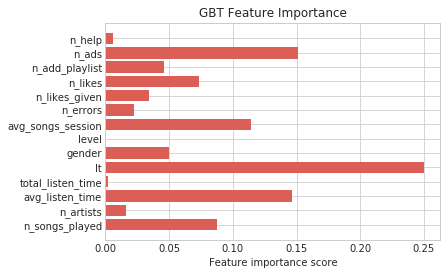

In [65]:
gbt_feature_importance = [i for i in cv_model_gbt.bestModel.featureImportances]  # store the values in a list
gbt_feature_names = df_features.columns[:-3]  # store the feature names

y_pos = np.arange(len(gbt_feature_names))  # set ticks
 
plt.barh(y_pos, gbt_feature_importance, align='center')  # plot feature importance values

# describe plot
plt.yticks(y_pos, gbt_feature_names)
plt.xlabel('Feature importance score')
plt.title('GBT Feature Importance')

#plt.savefig('GBT feature Importance.png', dpi=300)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.